# Nonuniform sensitivity

## Background

Not all pixels in a camera have the same sensitivity to light: there are
intrinsic differences from pixel-to-pixel. Vignetting, a dimming near the
corners of an image caused by the optical system to which the camera is
attached, and dust on optical elements such as filters, the glass window
covering the CCD, and the CCD chip itself can also block some light.

Vignetting and dust can reduce the amount of light reaching the CCD chip while
pixel-to-pixel sensitivity variations affects the counts read from the chip.

The code to produce the simulated sensitivity map (aka flat image) is long
enough that is not included in this notebook. We load it instead from
[image_sim.py](image_sim.py).

In [4]:
!pip install photutils

import numpy as np

from astropy import visualization as aviz
from astropy.nddata.blocks import block_reduce
from astropy.nddata.utils import Cutout2D
from matplotlib import pyplot as plt

import os

import numpy as np

from astropy.modeling.models import Gaussian2D, RickerWavelet2D, Const2D
from photutils.aperture import EllipticalAperture
from photutils.datasets import make_model_image, make_model_params
from photutils.psf import CircularGaussianPSF

# To use a seed, set it in the environment. Useful for minimizing changes when
# publishing the book.
seed = os.getenv('GUIDE_RANDOM_SEED', None)

if seed is not None:
    seed = int(seed)

default_rng = np.random.default_rng(seed)


def read_noise(image, amount, gain=1):
    """
    Generate simulated read noise.

    Parameters
    ----------

    image: numpy array
        Image whose shape the noise array should match.
    amount : float
        Amount of read noise, in electrons.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    shape = image.shape

    noise = default_rng.normal(scale=amount / gain, size=shape)

    return noise


def bias(image, value, realistic=False):
    """
    Generate simulated bias image.

    Parameters
    ----------

    image: numpy array
        Image whose shape the bias array should match.
    value: float
        Bias level to add.
    realistic : bool, optional
        If ``True``, add some clomuns with somewhat higher bias value
        (a not uncommon thing)
    """
    # This is the whole thing: the bias is really suppose to be a constant
    # offset!
    bias_im = np.zeros_like(image) + value

    # If we want a more realistic bias we need to do a little more work.
    if realistic:
        shape = image.shape
        number_of_colums = 5

        # We want a random-looking variation in the bias, but unlike the
        # readnoise the bias should *not* change from image to image, so we
        # make sure to always generate the same "random" numbers.
        rng = np.random.RandomState(seed=8392)  # 20180520
        columns = rng.randint(0, shape[1], size=number_of_colums)
        # This adds a little random-looking noise into the data.
        col_pattern = rng.randint(0, int(0.1 * value), size=shape[0])

        # Make the chosen columns a little brighter than the rest...
        for c in columns:
            bias_im[:, c] = value + col_pattern

    return bias_im


def dark_current(image, current, exposure_time, gain=1.0, hot_pixels=False):
    """
    Simulate dark current in a CCD, optionally including hot pixels.

    Parameters
    ----------

    image : numpy array
        Image whose shape the cosmic array should match.
    current : float
        Dark current, in electrons/pixel/second, which is the way
        manufacturers typically report it.
    exposure_time : float
        Length of the simulated exposure, in seconds.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    hot_pixels : bool, optional
        If ``True``, add hot pixels to the image.

    Returns
    -------

    numpy array
        An array the same shape and dtype as the input containing dark counts
        in units of ADU.
    """

    # dark current for every pixel; we'll modify the current for some pixels if
    # the user wants hot pixels.
    base_current = current * exposure_time / gain

    # This random number generation should change on each call.
    dark_im = default_rng.poisson(base_current, size=image.shape)

    if hot_pixels:
        # We'll set 0.01% of the pixels to be hot; that is probably too high
        # but should ensure they are visible.
        y_max, x_max = dark_im.shape

        n_hot = int(0.0001 * x_max * y_max)

        # Like with the bias image, we want the hot pixels to always be in the
        # same places (at least for the same image size) but also want them to
        # appear to be randomly distributed. So we set a random number seed to
        # ensure we always get the same thing.
        rng = np.random.RandomState(16201649)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)

        hot_current = 10000 * current

        dark_im[(hot_y, hot_x)] = hot_current * exposure_time / gain

    return dark_im


def sky_background(image, sky_counts, gain=1):
    """
    Generate sky background, optionally including a gradient across the
    image (because some times Moons happen).

    Parameters
    ----------

    image : numpy array
        Image whose shape the cosmic array should match.
    sky_counts : float
        The target value for the number of counts (as opposed to electrons or
        photons) from the sky.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    sky_im = default_rng.poisson(sky_counts * gain, size=image.shape) / gain

    return sky_im


def stars(image, number, max_counts=10000, gain=1, fwhm=4):
    """
    Add some stars to the image.
    """
    psf_model = CircularGaussianPSF(fwhm=fwhm)
    max_counts *= 100  # approx. peak amplitude to flux
    params = make_model_params(image.shape, n_sources=number,
                               flux=(max_counts / 10, max_counts),
                               min_separation=20,
                               border_size=20, seed=12345)

    return make_model_image(image.shape, psf_model, params,
                            progress_bar=True)


def make_cosmic_rays(image, number, strength=10000):
    """
    Generate an image with a few cosmic rays.

    Parameters
    ----------

    image numpy array
        Image whose shape the cosmic array should match.
    number: float
        Number of cosmic rays to add to the image.
    strength : float, optional
        Pixel count in the cosmic rays.
    """

    cr_image = np.zeros_like(image)

    # Yes, the order below is correct. The x axis is the column, which
    # is the second index.
    max_y, max_x = cr_image.shape

    # Get the smallest dimension to ensure the cosmic rays are within the image
    maximum_pos = np.min(cr_image.shape)
    # These will be center points of the cosmic rays, which we place away from
    # the edges to ensure they are visible.
    xy_cr = default_rng.integers(0.1 * maximum_pos, 0.9 * maximum_pos,
                                 size=[number, 2])

    cr_length = 5  # pixels, a little big
    cr_width = 2
    theta_cr = 2 * np.pi * default_rng.uniform()
    apertures = EllipticalAperture(xy_cr, cr_length, cr_width, theta_cr)
    masks = apertures.to_mask(method='center')
    for mask in masks:
        cr_image += strength * mask.to_image(shape=cr_image.shape)

    return cr_image


# Functions related to simulated flat images

def make_one_donut(center, diameter=10, amplitude=0.25):
    sigma = diameter / 2
    mh = RickerWavelet2D(amplitude=amplitude,
                      x_0=center[0], y_0=center[1],
                      sigma=sigma)
    gauss = Gaussian2D(amplitude=amplitude,
                       x_mean=center[0], y_mean=center[1],
                       x_stddev=sigma, y_stddev=sigma)
    return Const2D(amplitude=1) + (mh - gauss)


def add_donuts(image, number=20):
    """
    Create a transfer function, i.e. matrix by which you multiply
    input counts to obtain actual counts.

    Parameters
    ----------


    image : numpy array
        Image whose shape the cosmic array should match.

    number : int, optional
        Number of dust donuts to add.
    """

    y, x = np.indices(image.shape)

    # The dust donuts should always be in the same place...
    rng = np.random.RandomState(43901)
    shape = np.array(image.shape)
    border_padding = 50

    # We'll make the dust specks range from 1% to 5% of the image size, but
    # only in a couple of sizes. The dust grains themselves are fairly uniform
    # in size (I think), and there are only a fwe elements on which dust can
    # settle. Size on the image is determined by size of the dust and how far
    # it is from the CCD chip.

    min_diam = int(0.02 * shape.max())
    max_diam = int(0.05 * shape.max())

    # Weight towards the smaller donuts because it looks more like real flats..
    diameters = rng.choice([min_diam, min_diam, min_diam, max_diam],
                           size=number)

    # Add a little variation in amplitude
    amplitudes = rng.normal(0.25, 0.05, size=number)
    center_x = rng.randint(border_padding,
                           high=shape[1] - border_padding, size=number)
    center_y = rng.randint(border_padding,
                           high=shape[0] - border_padding, size=number)
    centers = [[x, y] for x, y in zip(center_x, center_y)]

    donut_model = make_one_donut(centers[0], diameter=diameters[0],
                                 amplitude=amplitudes[0])
    donut_im = donut_model(x, y)
    idx = 1
    for center, diam, amplitude in zip(centers[1:],
                                       diameters[1:],
                                       amplitudes[1:]):
        idx += 1
        donut_model = make_one_donut(center, diameter=diam,
                                      amplitude=amplitude)
        donut_im += donut_model(x, y)

    donut_im /= number

    return donut_im


def sensitivity_variations(image, vignetting=True, dust=True):
    """
    Create a transfer function, i.e. matrix by which you multiply input
    counts to obtain actual counts.

    Parameters
    ----------


    image : numpy array
        Image whose shape the cosmic array should match.

    vignetting : bool, optional
        If ``True``, darken image near corners.

    dust : bool, optional
        If ``True``, add some plausible-looking dust.
    """

    sensitivity = np.zeros_like(image) + 1.0
    shape = np.array(sensitivity.shape)

    if dust or vignetting:
        # Yes, this should be y, x.
        y, x = np.indices(sensitivity.shape)

    if vignetting:
        # Generate very wide gaussian centered on the center of the image,
        # multiply the sensitivity by it.
        vign_model = Gaussian2D(amplitude=1,
                                x_mean=shape[0] / 2, y_mean=shape[1] / 2,
                                x_stddev=2 * shape.max(),
                                y_stddev=2 * shape.max())
        vign_im = vign_model(x, y)
        sensitivity *= vign_im

    if dust:
        dust_im = add_donuts(image, number=40)
        dust_im = dust_im / dust_im.max()
        sensitivity *= dust_im

    return sensitivity

def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.

    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.3 MB/s eta 0:00:00


## A sample flat image

The sample flat image below has the same size as the simulated image in the
previous notebook.

In [5]:
image = np.zeros([2000, 2000])
flat = sensitivity_variations(image)

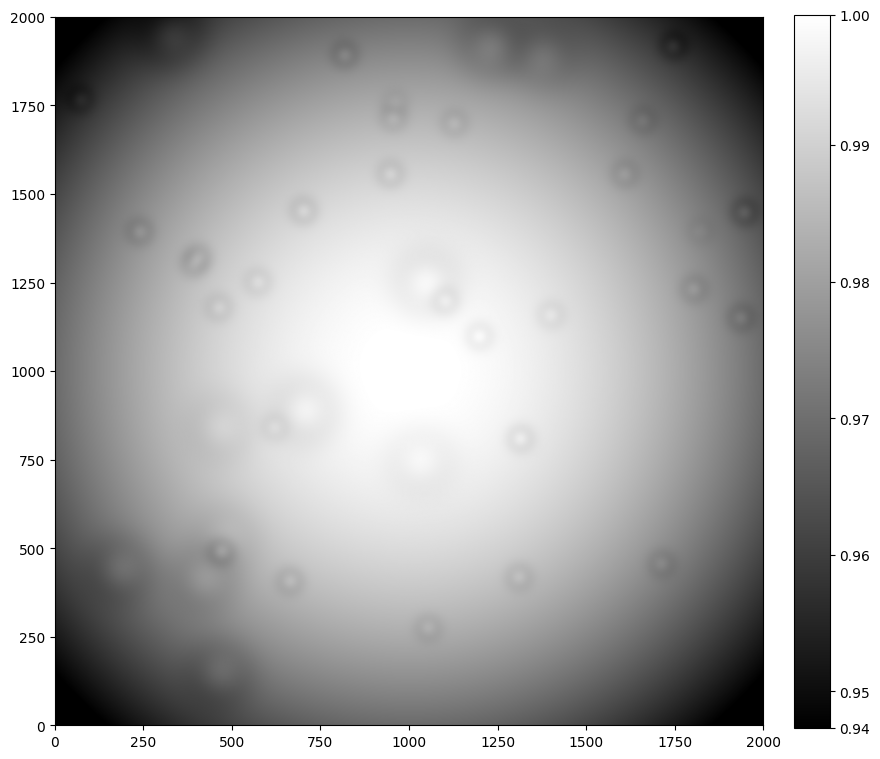

In [6]:
show_image(flat, cmap='gray')

The "donuts" in the image are dust on elements like filters in the optical path.
Note that the size of the variations is small, a few percent at most.

## Effect of nonuniform sensitivity on images

Recall that an image read off a CCD, ignoring variations in sensitivity, can be
thought of as a combination of several pieces:

$$
\text{image} = \text{bias} + \text{noise} + \text{dark current} + \text{sky} + \text{stars}
$$

The effect of sensitivity variations is to reduce the amount of *light* reaching
the sensor. In the equation above, that means that the flat multiplies just the
sky and stars portion of the input:

$$
\text{image} = \text{bias} + \text{noise} + \text{dark current} + \text{flat} \times (\text{sky} + \text{stars})
$$


## A realistic image

In the cell below we construct the last image from the previous notebook. Recall
that there we used a read noise of 5 electrons/pixel, dark current of 0.1
electron/pix/sec, bias level of 1100, and sky background of 20 counts.

In [8]:
gain = 1.0
exposure = 30.0
dark = 0.1
sky_counts = 20
bias_level = 1100
read_noise_electrons = 5
max_star_counts = 2000
bias_only = bias(image, bias_level, realistic=True)
noise_only = read_noise(image, read_noise_electrons, gain=gain)
dark_only = dark_current(image, dark, exposure, gain=gain, hot_pixels=True)
sky_only = sky_background(image, sky_counts, gain=gain)
stars_only = stars(image, 50, max_counts=max_star_counts)

Add model sources:   0%|          | 0/50 [00:00<?, ?it/s]

The individual pieces of the image are assembled below; it is the inclusion of
the flat that makes this the closest of the simulated images to a realistic
images.

In [9]:
final_image = bias_only + noise_only + dark_only + flat * (sky_only + stars_only)

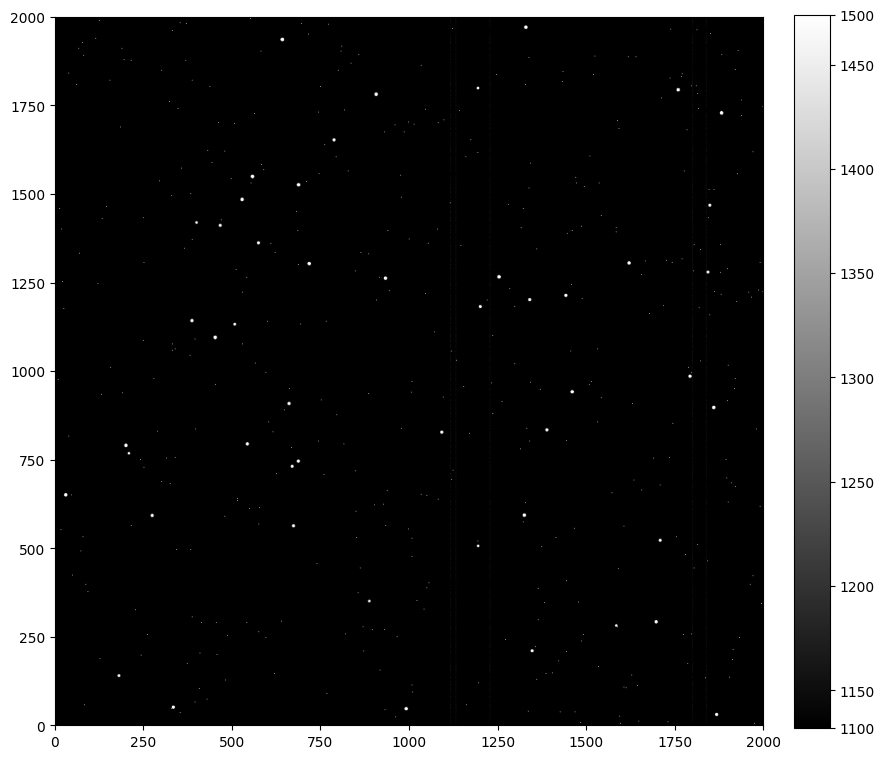

In [10]:
show_image(final_image, cmap='gray', percu=99.9)

Visually, this does not look any different than the final image in the previous
notebook; the effects of sensitivity variations are typically not evident in raw
images unless the sky background is large.

You can see the effect by artificially increasing the sky background.

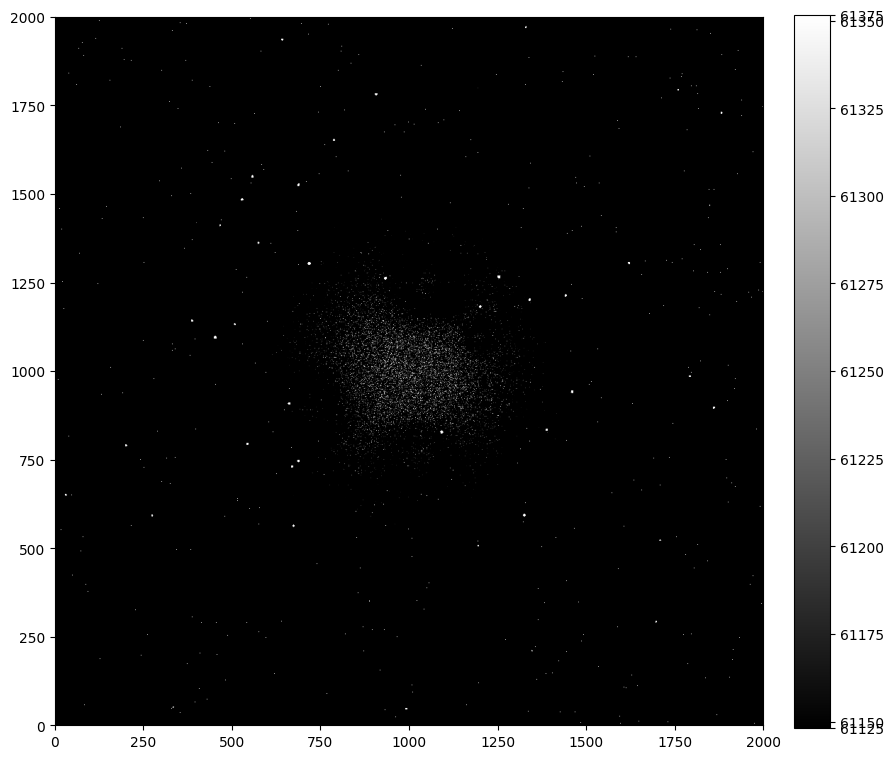

In [12]:
final_image2 = bias_only + noise_only + dark_only + flat * (sky_background(image, 3000 * sky_counts, gain=gain) + stars_only)
show_image(final_image2, cmap='gray', percu=99.9)